c:\Users\eduya\github-classroom\4-semestre\Aps-e-projetos\projetoML\ames\data
             count unique      top  freq
Exterior.1st  2901     16  VinylSd  1025
Exterior.2nd  2901     17  VinylSd  1012


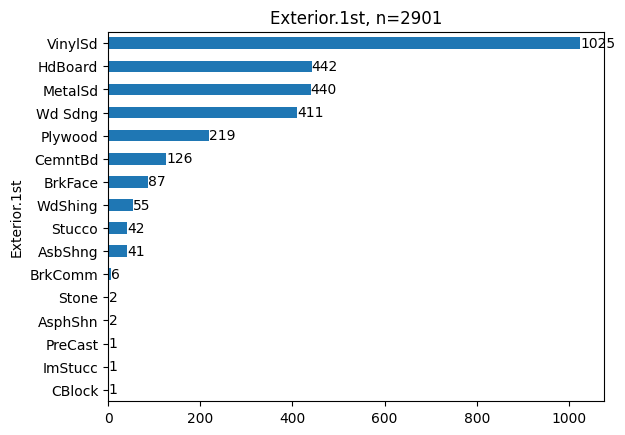

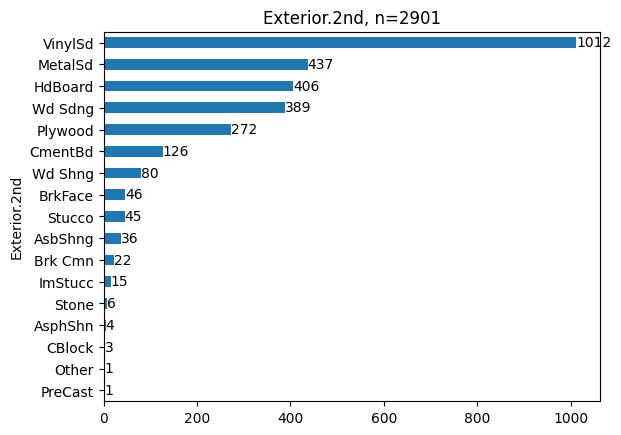

           count unique      top  freq
Roof.Matl   2901      8  CompShg  2858
Roof.Style  2901      6    Gable  2301


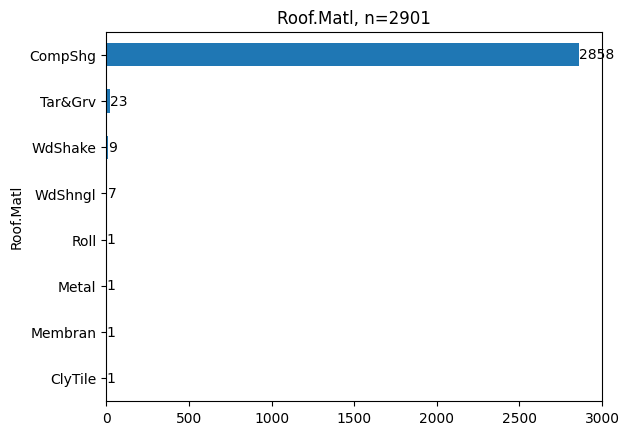

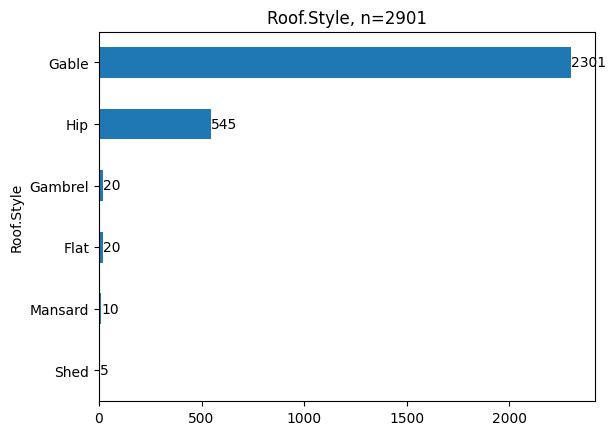

<class 'pandas.core.series.Series'>
Index: 2901 entries, 0 to 2929
Series name: Mas.Vnr.Type
Non-Null Count  Dtype   
--------------  -----   
1155 non-null   category
dtypes: category(1)
memory usage: 25.5 KB
             count  unique  top  freq
MS.SubClass   2901      16   20  1074


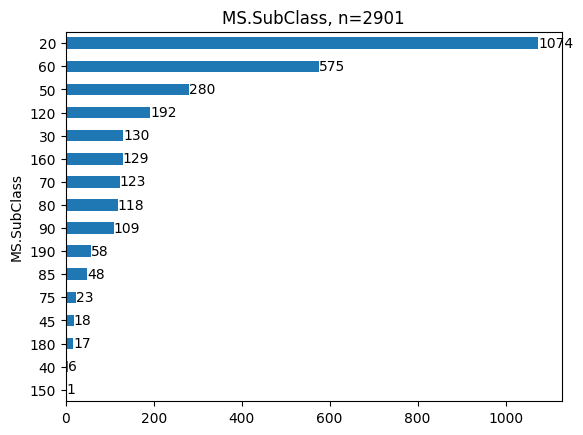

<class 'pandas.core.series.Series'>
Index: 2880 entries, 0 to 2929
Series name: Garage.Type
Non-Null Count  Dtype   
--------------  -----   
2733 non-null   category
dtypes: category(1)
memory usage: 25.4 KB
           count unique    top  freq
Electrical  2879      5  SBrkr  2643


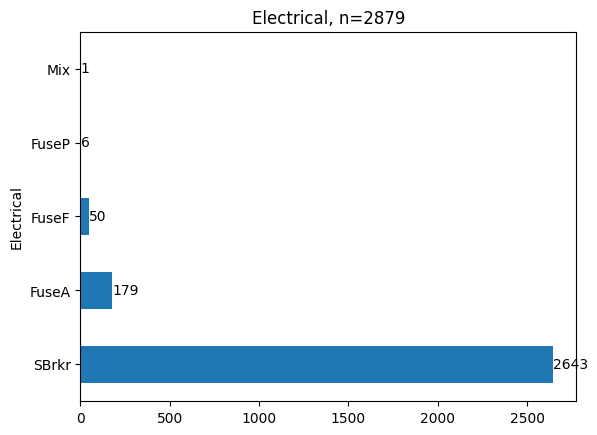

<class 'pandas.core.frame.DataFrame'>
Index: 2880 entries, 0 to 2929
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Lot.Shape       2880 non-null   category
 1   Land.Slope      2880 non-null   category
 2   Overall.Qual    2880 non-null   category
 3   Overall.Cond    2880 non-null   category
 4   Exter.Qual      2880 non-null   category
 5   Exter.Cond      2880 non-null   category
 6   Bsmt.Qual       2805 non-null   category
 7   Bsmt.Cond       2805 non-null   category
 8   Bsmt.Exposure   2802 non-null   category
 9   BsmtFin.Type.1  2805 non-null   category
 10  BsmtFin.Type.2  2804 non-null   category
 11  Heating.QC      2880 non-null   category
 12  Electrical      2880 non-null   category
 13  Kitchen.Qual    2880 non-null   category
 14  Functional      2880 non-null   category
 15  Paved.Drive     2880 non-null   category
 16  Fence           2880 non-null   category
dtypes: category(17)
mem

In [91]:
import pathlib
import pickle


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 500)

DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

processed_file_path = DATA_DIR / 'processed' / 'ames_with_correct_types.pkl'

with open(processed_file_path, 'rb') as file:
    (
        data,
        continuous_variables,
        discrete_variables,
        ordinal_variables,
        categorical_variables,
    ) = pickle.load(file)

def plot_categoricals(data, cols, sorted=True):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        ser = data[col].value_counts()
        if sorted:
            ser = ser.sort_values()
        else:
            ser = ser.sort_index()
        ax = ser.plot.barh()
        for container in ax.containers:
            ax.bar_label(container)
        plt.title(f'{col}, n={int(val)}')
        plt.show()

data['MS.Zoning'].unique()
data['MS.Zoning'].value_counts()
selection = ~(data['MS.Zoning'].isin(['A (agr)', 'C (all)', 'I (all)']))
selection.value_counts()
data = data[selection]
data['MS.Zoning'] = data['MS.Zoning'].cat.remove_unused_categories()
data['MS.Zoning'].value_counts()

data['Sale.Type'].value_counts()
data['Sale.Type'].unique()

processed_data = data.copy()

def remap_categories(
    series: pd.Series,
    old_categories: tuple[str],
    new_category: str,
) -> pd.Series:
    # Add the new category to the list of valid categories.
    series = series.cat.add_categories(new_category)

    # Set all items of the old categories as the new category.
    remapped_items = series.isin(old_categories)
    series.loc[remapped_items] = new_category

    # Clean up the list of categories, the old categories no longer exist.
    series = series.cat.remove_unused_categories()

    return series

processed_data['Sale.Type'] = remap_categories(
    series=processed_data['Sale.Type'],
    old_categories=('WD ', 'CWD', 'VWD'),
    new_category='GroupedWD',
)

processed_data['Sale.Type'] = remap_categories(
    series=processed_data['Sale.Type'],
    old_categories=('COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw'),
    new_category='Other',
)

processed_data['Sale.Type'].value_counts()

data = processed_data
data['Street'].value_counts()
data = data.drop(columns='Street')
data['Condition.1'].value_counts()
data['Condition.2'].value_counts()
pd.crosstab(data['Condition.1'], data['Condition.2'])

processed_data = data.copy()
for col in ('Condition.1', 'Condition.2'):
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('RRAn', 'RRAe', 'RRNn', 'RRNe'),
        new_category='Railroad',
    )
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('Feedr', 'Artery'),
        new_category='Roads',
    )
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('PosA', 'PosN'),
        new_category='Positive',
    )
processed_data['Condition.1'].value_counts()
processed_data['Condition.2'].value_counts()
pd.crosstab(processed_data['Condition.1'], processed_data['Condition.2'])
processed_data['Condition'] = pd.Series(
    index=processed_data.index,
    dtype=pd.CategoricalDtype(categories=(
        'Norm',
        'Railroad',
        'Roads',
        'Positive',
        'RoadsAndRailroad',
    )),
)

norm_items = processed_data['Condition.1'] == 'Norm'
processed_data['Condition'][norm_items] = 'Norm'

railroad_items = \
    (processed_data['Condition.1'] == 'Railroad') \
    & (processed_data['Condition.2'] == 'Norm')
processed_data['Condition'][railroad_items] = 'Railroad'

roads_items = \
    (processed_data['Condition.1'] == 'Roads') \
    & (processed_data['Condition.2'] != 'Railroad')
processed_data['Condition'][roads_items] = 'Roads'

positive_items = processed_data['Condition.1'] == 'Positive'
processed_data['Condition'][positive_items] = 'Positive'

roads_and_railroad_items = \
    ( \
        (processed_data['Condition.1'] == 'Railroad') \
        & (processed_data['Condition.2'] == 'Roads')
    ) \
    | ( \
        (processed_data['Condition.1'] == 'Roads') \
        & (processed_data['Condition.2'] == 'Railroad') \
    )
processed_data['Condition'][roads_and_railroad_items] = 'RoadsAndRailroad'

processed_data['Condition'].value_counts()

processed_data = processed_data.drop(columns=['Condition.1', 'Condition.2'])

data = processed_data

data['HasShed'] = data['Misc.Feature'] == 'Shed'
data = data.drop(columns='Misc.Feature')

data['HasShed'].value_counts()

data['HasAlley'] = ~data['Alley'].isna()
data = data.drop(columns='Alley')

data['HasAlley'].value_counts()

plot_categoricals(data, ['Exterior.1st', 'Exterior.2nd'])

data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('Brk Cmn', ),
    new_category='BrkComm',
)
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('CmentBd', ),
    new_category='CemntBd',
)
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('Wd Shng', ),
    new_category='WdShing',
)

for col in ('Exterior.1st', 'Exterior.2nd'):
    categories = data[col].cat.categories
    data[col] = data[col].cat.reorder_categories(sorted(categories))


pd.crosstab(data['Exterior.1st'], data['Exterior.2nd'])

processed_data = data.copy()

mat_count = processed_data['Exterior.1st'].value_counts()
mat_count

rare_materials = list(mat_count[mat_count < 40].index)
rare_materials

processed_data['Exterior'] = remap_categories(
    series=processed_data['Exterior.1st'],
    old_categories=rare_materials,
    new_category='Other',
)
processed_data = processed_data.drop(columns=['Exterior.1st', 'Exterior.2nd'])

processed_data['Exterior'].value_counts()

data = processed_data
data = data.drop(columns='Heating')

plot_categoricals(data, ['Roof.Matl', 'Roof.Style'])
data = data.drop(columns='Roof.Matl')

data['Roof.Style'] = remap_categories(
    series=data['Roof.Style'],
    old_categories=[
        'Flat',
        'Gambrel',
        'Mansard',
        'Shed',
    ],
    new_category='Other',
)

data['Roof.Style'].value_counts()

data['Mas.Vnr.Type'].info()

data['Mas.Vnr.Type'].value_counts()

data['Mas.Vnr.Type'] = remap_categories(
    series=data['Mas.Vnr.Type'],
    old_categories=[
        'BrkCmn',
        'CBlock',
    ],
    new_category='Other',
)

data['Mas.Vnr.Type'] = data['Mas.Vnr.Type'].cat.add_categories('None')
data['Mas.Vnr.Type'][data['Mas.Vnr.Type'].isna()] = 'None'

data['Mas.Vnr.Type'].value_counts()

plot_categoricals(data, ['MS.SubClass'])

data['MS.SubClass'] = remap_categories(
    series=data['MS.SubClass'],
    old_categories=[75, 45, 180, 40, 150],
    new_category='Other',
)

data['MS.SubClass'].value_counts()

data['Foundation'] = remap_categories(
    series=data['Foundation'],
    old_categories=['Slab', 'Stone', 'Wood'],
    new_category='Other',
)

data['Neighborhood'].value_counts()

selection = ~data['Neighborhood'].isin([
    'Blueste',
    'Greens',
    'GrnHill',
    'Landmrk',
])
data = data[selection]

data['Neighborhood'] = data['Neighborhood'].cat.remove_unused_categories()

data['Neighborhood'].value_counts()

data['Garage.Type'].info()
data['Garage.Type'].value_counts()

data['Garage.Type'] = data['Garage.Type'].cat.add_categories(['NoGarage'])
data['Garage.Type'][data['Garage.Type'].isna()] = 'NoGarage'

data['Garage.Type'].value_counts()

all_categorical = data.select_dtypes('category').columns

new_categorical_variables = [ \
    col for col in all_categorical \
    if not col in ordinal_variables \
]

data = data.drop(columns='Utilities')

data = data.drop(columns='Pool.QC')

data['Fence'].value_counts().sort_index()

old_categories = list(data['Fence'].cat.categories)
old_categories

new_categories = old_categories + ['NoFence']
new_categories

data['Fence'] = data['Fence'].cat.set_categories(new_categories)

data['Fence'].dtype

data['Fence'][data['Fence'].isna()] = 'NoFence'

data['Fence'].value_counts().sort_index()

data['Fireplace.Qu'].value_counts().sort_index()

data['Fireplaces'].value_counts()

data = data.drop(columns='Fireplace.Qu')

data = data.drop(columns=['Garage.Cond', 'Garage.Qual'])

data['Garage.Finish'] = data['Garage.Finish'] \
    .cat \
    .as_unordered() \
    .cat \
    .add_categories(['NoGarage'])
data['Garage.Finish'][data['Garage.Finish'].isna()] = 'NoGarage'

data['Garage.Finish'].value_counts()

data['Garage.Finish'].dtype

data['Garage.Finish'].cat.ordered

data['Electrical'].isna().value_counts()

plot_categoricals(data, ['Electrical'], sorted=False)

data['Electrical'][data['Electrical'].isna()] = 'SBrkr'

ordinal_columns = [col for col in data.select_dtypes('category') if data[col].cat.ordered]

data[ordinal_columns].info()

data['Bsmt.Exposure'].unique()

data['Bsmt.Exposure'][data['Bsmt.Exposure'].isna()] = 'NA'
data['Bsmt.Exposure'] = data['Bsmt.Exposure'] \
    .cat \
    .as_unordered() \
    .cat \
    .remove_unused_categories()

for col in ('Bsmt.Qual', 'Bsmt.Cond', 'BsmtFin.Type.1', 'BsmtFin.Type.2'):
    data[col] = data[col].cat.add_categories(['NA'])
    data[col][data[col].isna()] = 'NA'
    data[col] = data[col] \
        .cat \
        .as_unordered() \
        .cat \
        .remove_unused_categories()
    
data['Bsmt.Cond'][data['Bsmt.Cond'] == 'Po'] = 'Fa'
data['Bsmt.Cond'][data['Bsmt.Cond'] == 'Ex'] = 'Gd'
data['Bsmt.Cond'] = data['Bsmt.Cond'].cat.remove_unused_categories()

data['Bsmt.Cond'].value_counts()

data[ordinal_columns].info()

def plot_numericals(data, cols):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    n = data.shape[0]
    b = int(np.sqrt(n))
    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        data[col].plot.hist(bins=b)
        plt.title(f'{col}, n={int(val)}')
        plt.show()


data['SalePrice'].describe()

data['SalePrice'] = data['SalePrice'].apply(np.log10)

data['SalePrice'].describe()

data['Lot.Frontage'].info()

missing_lot_frontage = data['Lot.Frontage'].isna()

data['MS.SubClass'][missing_lot_frontage].value_counts()

data['Lot.Config'][missing_lot_frontage].value_counts()

data['Land.Contour'][missing_lot_frontage].value_counts()

data[['Lot.Frontage', 'Lot.Area']].corr()
aux_data = data[['Lot.Frontage', 'Lot.Area']].copy()
aux_data['Sqrt.Lot.Area'] = aux_data['Lot.Area'].apply(np.sqrt)

aux_data = data[['Lot.Frontage', 'Lot.Area']].copy()
aux_data['Sqrt.Lot.Area'] = aux_data['Lot.Area'].apply(np.sqrt)

aux_data[['Lot.Frontage', 'Sqrt.Lot.Area']].corr()

data['Lot.Frontage'] = data['Lot.Frontage'].fillna(data['Lot.Frontage'].median())

data['Lot.Frontage'].info()

data['Garage.Yr.Blt'].describe()

garage_age = data['Yr.Sold'] - data['Garage.Yr.Blt']
garage_age.describe()

data[garage_age < 0.0].transpose()

garage_age[garage_age < 0.0] = 0.0

data = data.drop(columns='Garage.Yr.Blt')
data['Garage.Age'] = garage_age

data['Garage.Age'].info()

data['Garage.Type'][data['Garage.Age'].isna()].value_counts()

data['Garage.Age'] = data['Garage.Age'].fillna(data['Garage.Age'].median())

data[['Year.Remod.Add', 'Year.Built', 'Yr.Sold']].describe()

remod_age = data['Yr.Sold'] - data['Year.Remod.Add']
remod_age.describe()

data[remod_age < 0.0].transpose()

remod_age[remod_age < 0.0] = 0.0

house_age = data['Yr.Sold'] - data['Year.Built']
house_age.describe()

data[house_age < 0.0].transpose()

house_age[house_age < 0.0] = 0.0

data = data.drop(columns=['Year.Remod.Add', 'Year.Built'])
data['Remod.Age'] = remod_age
data['House.Age'] = house_age

data['Mas.Vnr.Area'].info()

data['Mas.Vnr.Type'][data['Mas.Vnr.Area'].isna()].value_counts()

data.loc[data['Mas.Vnr.Area'].isna(), 'Mas.Vnr.Area'] = 0.0

num_houses = data.shape[0]
num_houses_with_pool = data[data['Pool.Area'] > 0].shape[0]
print(f'Out of {num_houses} houses, only {num_houses_with_pool} have a pool.')

data.info()
data = data.dropna(axis=0)
data.info()

for col in data.select_dtypes('category').columns:
    data[col] = data[col].cat.remove_unused_categories()

numerical_data = data.select_dtypes('number').drop(columns='SalePrice').copy()
target = data['SalePrice'].copy()

numerical_data.corrwith(target).sort_values()

categorical_columns = data.select_dtypes('category').columns

corr = data.corr(numeric_only=True)
corr

clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'

with open(clean_data_path, 'wb') as file:
    pickle.dump(data, file)

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2877 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2877 non-null   category
 1   MS.Zoning        2877 non-null   category
 2   Lot.Frontage     2877 non-null   float64 
 3   Lot.Area         2877 non-null   float64 
 4   Lot.Shape        2877 non-null   category
 5   Land.Contour     2877 non-null   category
 6   Lot.Config       2877 non-null   category
 7   Land.Slope       2877 non-null   category
 8   Neighborhood     2877 non-null   category
 9   Bldg.Type        2877 non-null   category
 10  House.Style      2877 non-null   category
 11  Overall.Qual     2877 non-null   category
 12  Overall.Cond     2877 non-null   category
 13  Roof.Style       2877 non-null   category
 14  Mas.Vnr.Type     2877 non-null   category
 15  Mas.Vnr.Area     2877 non-null   float64 
 16  Exter.Qual       2877 non-null   category
 17  

In [93]:
import pathlib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class AmesDataProcessor:
    def __init__(self, data_dir):
        self.data_dir = pathlib.Path(data_dir)
        pd.set_option('display.max_rows', 500)
        
    def load_data(self):
        """Load the initial processed data from pickle file."""
        processed_file_path = self.data_dir / 'processed' / 'ames_with_correct_types.pkl'
        with open(processed_file_path, 'rb') as file:
            (self.data,
             self.continuous_variables,
             self.discrete_variables,
             self.ordinal_variables,
             self.categorical_variables) = pickle.load(file)
    
    @staticmethod
    def remap_categories(series: pd.Series, old_categories: tuple[str], new_category: str) -> pd.Series:
        """Remap multiple categories to a single new category."""
        series = series.cat.add_categories(new_category)
        remapped_items = series.isin(old_categories)
        series.loc[remapped_items] = new_category
        return series.cat.remove_unused_categories()
    
    def process_zoning(self):
        """Process MS.Zoning column."""
        selection = ~(self.data['MS.Zoning'].isin(['A (agr)', 'C (all)', 'I (all)']))
        self.data = self.data[selection]
        self.data['MS.Zoning'] = self.data['MS.Zoning'].cat.remove_unused_categories()
    
    def process_sale_type(self):
        """Process Sale.Type column."""
        self.data['Sale.Type'] = self.remap_categories(
            series=self.data['Sale.Type'],
            old_categories=('WD ', 'CWD', 'VWD'),
            new_category='GroupedWD'
        )
        self.data['Sale.Type'] = self.remap_categories(
            series=self.data['Sale.Type'],
            old_categories=('COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw'),
            new_category='Other'
        )
    
    def process_conditions(self):
        """Process Condition columns."""
        for col in ('Condition.1', 'Condition.2'):
            self.data[col] = self.remap_categories(
                series=self.data[col],
                old_categories=('RRAn', 'RRAe', 'RRNn', 'RRNe'),
                new_category='Railroad'
            )
            self.data[col] = self.remap_categories(
                series=self.data[col],
                old_categories=('Feedr', 'Artery'),
                new_category='Roads'
            )
            self.data[col] = self.remap_categories(
                series=self.data[col],
                old_categories=('PosA', 'PosN'),
                new_category='Positive'
            )
        
        self.create_combined_condition()
        self.data = self.data.drop(columns=['Condition.1', 'Condition.2'])
    
    def create_combined_condition(self):
        """Create combined Condition column from Condition.1 and Condition.2."""
        self.data['Condition'] = pd.Series(
            index=self.data.index,
            dtype=pd.CategoricalDtype(categories=(
                'Norm', 'Railroad', 'Roads', 'Positive', 'RoadsAndRailroad'
            ))
        )
        
        # Set conditions based on rules
        norm_items = self.data['Condition.1'] == 'Norm'
        self.data['Condition'][norm_items] = 'Norm'
        
        railroad_items = (self.data['Condition.1'] == 'Railroad') & (self.data['Condition.2'] == 'Norm')
        self.data['Condition'][railroad_items] = 'Railroad'
        
        roads_items = (self.data['Condition.1'] == 'Roads') & (self.data['Condition.2'] != 'Railroad')
        self.data['Condition'][roads_items] = 'Roads'
        
        positive_items = self.data['Condition.1'] == 'Positive'
        self.data['Condition'][positive_items] = 'Positive'
        
        roads_and_railroad_items = (
            (self.data['Condition.1'] == 'Railroad') & (self.data['Condition.2'] == 'Roads')
        ) | (
            (self.data['Condition.1'] == 'Roads') & (self.data['Condition.2'] == 'Railroad')
        )
        self.data['Condition'][roads_and_railroad_items] = 'RoadsAndRailroad'
    
    def process_features(self):
        """Process miscellaneous features."""
        # Create HasShed feature
        self.data['HasShed'] = self.data['Misc.Feature'] == 'Shed'
        self.data = self.data.drop(columns='Misc.Feature')
        
        # Create HasAlley feature
        self.data['HasAlley'] = ~self.data['Alley'].isna()
        self.data = self.data.drop(columns='Alley')
    
    def process_exterior(self):
        """Process exterior-related columns."""
        # Fix inconsistencies in Exterior.2nd
        self.data['Exterior.2nd'] = self.remap_categories(
            series=self.data['Exterior.2nd'],
            old_categories=('Brk Cmn',),
            new_category='BrkComm'
        )
        self.data['Exterior.2nd'] = self.remap_categories(
            series=self.data['Exterior.2nd'],
            old_categories=('CmentBd',),
            new_category='CemntBd'
        )
        self.data['Exterior.2nd'] = self.remap_categories(
            series=self.data['Exterior.2nd'],
            old_categories=('Wd Shng',),
            new_category='WdShing'
        )
        
        # Sort categories
        for col in ('Exterior.1st', 'Exterior.2nd'):
            categories = self.data[col].cat.categories
            self.data[col] = self.data[col].cat.reorder_categories(sorted(categories))
        
        # Group rare materials
        mat_count = self.data['Exterior.1st'].value_counts()
        rare_materials = list(mat_count[mat_count < 40].index)
        self.data['Exterior'] = self.remap_categories(
            series=self.data['Exterior.1st'],
            old_categories=rare_materials,
            new_category='Other'
        )
        self.data = self.data.drop(columns=['Exterior.1st', 'Exterior.2nd'])
    
    def process_numerical_features(self):
        """Process numerical features."""
        # Transform SalePrice
        self.data['SalePrice'] = self.data['SalePrice'].apply(np.log10)
        
        # Handle Lot.Frontage
        self.data['Lot.Frontage'] = self.data['Lot.Frontage'].fillna(self.data['Lot.Frontage'].median())
        
        # Process garage age
        self.process_garage_age()
        
        # Process house and remodeling age
        self.process_house_ages()
        
        # Handle masonry veneer area
        self.data.loc[self.data['Mas.Vnr.Area'].isna(), 'Mas.Vnr.Area'] = 0.0
    
    def process_garage_age(self):
        """Process garage age-related features."""
        garage_age = self.data['Yr.Sold'] - self.data['Garage.Yr.Blt']
        garage_age[garage_age < 0.0] = 0.0
        self.data = self.data.drop(columns='Garage.Yr.Blt')
        self.data['Garage.Age'] = garage_age
        self.data['Garage.Age'] = self.data['Garage.Age'].fillna(self.data['Garage.Age'].median())
    
    def process_house_ages(self):
        """Process house age-related features."""
        remod_age = self.data['Yr.Sold'] - self.data['Year.Remod.Add']
        remod_age[remod_age < 0.0] = 0.0
        
        house_age = self.data['Yr.Sold'] - self.data['Year.Built']
        house_age[house_age < 0.0] = 0.0
        
        self.data = self.data.drop(columns=['Year.Remod.Add', 'Year.Built'])
        self.data['Remod.Age'] = remod_age
        self.data['House.Age'] = house_age
    
    def clean_data(self):
        """Perform final cleaning steps."""
        # Drop unnecessary columns
        columns_to_drop = ['Street', 'Utilities', 'Pool.QC', 'Fireplace.Qu',
                          'Garage.Cond', 'Garage.Qual', 'Heating']
        self.data = self.data.drop(columns=columns_to_drop)
        
        # Handle missing values
        self.data = self.data.dropna(axis=0)
        
        # Clean up categories
        for col in self.data.select_dtypes('category').columns:
            self.data[col] = self.data[col].cat.remove_unused_categories()
    
    def save_clean_data(self):
        """Save the cleaned data to a pickle file."""
        clean_data_path = self.data_dir / 'processed' / 'ames_clean.pkl'
        with open(clean_data_path, 'wb') as file:
            pickle.dump(self.data, file)
    
    def process_data(self):
        """Execute all data processing steps."""
        self.load_data()
        self.process_zoning()
        self.process_sale_type()
        self.process_conditions()
        self.process_features()
        self.process_exterior()
        self.process_numerical_features()
        self.clean_data()
        self.save_clean_data()
        return self.data

def main():
    data_dir = pathlib.Path.cwd().parent / 'data'
    processor = AmesDataProcessor(data_dir)
    processed_data = processor.process_data()
    print("Data processing completed successfully.")
    print(data.info())
    return processed_data

if __name__ == "__main__":
    main()

Data processing completed successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 2877 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2877 non-null   category
 1   MS.Zoning        2877 non-null   category
 2   Lot.Frontage     2877 non-null   float64 
 3   Lot.Area         2877 non-null   float64 
 4   Lot.Shape        2877 non-null   category
 5   Land.Contour     2877 non-null   category
 6   Lot.Config       2877 non-null   category
 7   Land.Slope       2877 non-null   category
 8   Neighborhood     2877 non-null   category
 9   Bldg.Type        2877 non-null   category
 10  House.Style      2877 non-null   category
 11  Overall.Qual     2877 non-null   category
 12  Overall.Cond     2877 non-null   category
 13  Roof.Style       2877 non-null   category
 14  Mas.Vnr.Type     2877 non-null   category
 15  Mas.Vnr.Area     2877 non-null   float64 
 16  Exter.Q